In [2]:
from bs4 import BeautifulSoup
from datetime import datetime
import json
import pandas as pd
import requests

In [15]:
# Set target URL
base_url = 'https://www.imdb.com/title/'
url_list = [
            'tt0417299',   # Avatar: The Last Airbender
            #'tt11126994',  # Arcane: League of Legends

            'tt1695360',   # The Legend Of Korra
            'tt1865718',   # Gravity Falls
            'tt8050756',   # The Owl House
            'tt8050740',   # Amphibia
            'tt2758770',   # Star Vs. The Forces Of Evil
            'tt3061046',   # Steven Universe
            'tt13714610',  # Steven Universe Future
            'tt4163486',   # Bee and PuppyCat
            'tt7745956',   # She-Ra And The Princesses Of Power
            'tt10482560',  # Kipo And The Age Of Wonderbeasts
            'tt3718778',   # Over The Garden Wall
            
            'tt10384610',  # Scissor Seven
            'tt3398228',   # Bojack Horseman
            'tt9248538',   # Kid Cosmic
            'tt9894516',   # Oni: Thunder God's Tale
            'tt8688814',   # The Dragon Prince
            'tt0108783',   # Gargoyles
            'tt0278238',   # Samurai Jack
            'tt1942683',   # The Amazing World of Gumball
            'tt1710308',   # Regular Show
            'tt0088500',   # Count Duckula
            'tt9561862'   # Love, Death & Robots
            ]

global_aux_df = pd.DataFrame()
global_reviews_df = pd.DataFrame()
global_main_df = pd.DataFrame()

for url_index, url in enumerate(url_list):

    # Get main page HTML information
    main_page = requests.get(base_url + url, headers={'User-Agent': 'Mozilla/5.0'})
    main_soup = BeautifulSoup(main_page.content, 'html.parser')

    # Number of Episodes
    n_episodes = main_soup.find_all('span', class_='ipc-title__subtext')[0].text

    # Number of Seasons
    seasons_html = main_soup.find('label', class_='ipc-simple-select__label')

    # Fix issue with Over the Garden Wall number of seasons
    try:
        n_seasons = int(seasons_html.text.split(' ')[0])
    except AttributeError as attribute_error:
        print('\nEcountered the following issue for Number of Seasons:', attribute_error, '\n')
        data_json = main_soup.find_all('script', id="__NEXT_DATA__")[0]
        data_attributes = json.loads(data_json.text)['props']['pageProps']
        n_seasons = data_attributes['mainColumnData']['episodes']['seasons'][0]['number'] 

    # List each season's URL
    seasons_urls = [base_url + url + '/episodes?season={}'.format(n+1) for n in range(n_seasons)]

##########################################################################################################
##########################################################################################################

####                                 AUXILIARY DATA

##########################################################################################################
##########################################################################################################

    auxiliary_data = {}

    # Get JSON data embedded in main page HTML containing general show information
    data_json = main_soup.find_all('script', id="__NEXT_DATA__")[0]
    data_attributes = json.loads(data_json.text)['props']['pageProps']['aboveTheFoldData']

    # Original Title
    original_title = data_attributes['originalTitleText']['text']
    auxiliary_data['Original Show Title'] = original_title

    print('Processing series', str(url_index + 1), 'of', str(len(url_list)) + ':', original_title)

    # Overall Rating
    overall_rating = data_attributes['ratingsSummary']['aggregateRating']
    auxiliary_data['Overall Rating'] = overall_rating

    # Overall Votes
    overall_votes = data_attributes['ratingsSummary']['voteCount']
    auxiliary_data['Total Votes'] = overall_votes

    # Episode Runtime
    runtime = str(int(data_attributes['runtime']['seconds'] / 60)) + 'min.'
    auxiliary_data['Runtime'] = runtime

    # Series Genres
    genres = [item['text'] for item in data_attributes['genres']['genres']]
    auxiliary_data['Genres'] = [genres]

    # Country of Origin
    country_of_origin = data_attributes['countriesOfOrigin']['countries'][0]['id']
    auxiliary_data['Country of Origin'] = country_of_origin

    # Air Dates (Years)
    start_year = data_attributes['releaseYear']['year']
    end_year = data_attributes['releaseYear']['endYear']
    auxiliary_data['Start Year'] = start_year
    auxiliary_data['End Year'] = end_year

    # Poster Image
    poster_image = data_attributes['primaryImage']['url']
    auxiliary_data['Poster Image'] = poster_image

    # Credits (Creators//Production Company/Writers)
    # Fix issue with Arcane missing show creators
    try:
        show_creators = [credit['name']['nameText']['text'] for credit in data_attributes['creatorsPageTitle'][0]['credits']]
    except IndexError as index_error:
        print('\nEcountered the following issue in', original_title, 'for Show Creators:', index_error, '\n')
        show_creators = ['--']

    production_company = data_attributes['production']['edges'][0]['node']['company']['companyText']['text']
    auxiliary_data['Show Creators'] = [show_creators]
    auxiliary_data['Production Company'] = production_company

    # Total Amount of Reviews
    n_reviews = data_attributes['reviews']['total']
    auxiliary_data['Total Reviews'] = n_reviews

    # Plot
    plot_text = data_attributes['plot']['plotText']['plainText']
    auxiliary_data['Plot'] = plot_text

    # Save current series data
    auxiliary_df = pd.DataFrame.from_dict(auxiliary_data)

    # Save data to global DataFrame
    global_aux_df = pd.concat([global_aux_df, auxiliary_df], axis=0)

##########################################################################################################
##########################################################################################################

####                                 REVIEWS DATA

##########################################################################################################
##########################################################################################################

    start_url = base_url + url + '/reviews'
    link = base_url + url + '/reviews/_ajax'

    params = {
            'ref_': 'undefined',
            'paginationKey': ''
            }

    reviews = {
            'Original Show Title': [],
            'Review Title': [],
            'Review Content': [],
            'Review Date': []
            }

    with requests.Session() as session:
        result = session.get(start_url, headers={'User-Agent': 'Mozilla/5.0'})

        while True:

            # Get reviews page HTML information
            soup = BeautifulSoup(result.text,'html.parser')
            for item in soup.select('.review-container'):

                # Review Title & Text
                review_title = item.find_all('a', class_='title')[0].text.strip()
                review_text = item.find_all('div', class_='text show-more__control')[0].text.strip().replace("n\\'t", "n't")
                review_date = ' '.join(item.find_all('div', class_='display-name-date')[0].text.split()[1:])

                # Save data
                reviews['Original Show Title'].append(original_title)
                reviews['Review Title'].append(review_title)
                reviews['Review Content'].append(review_text)
                reviews['Review Date'].append(review_date)

            # Load more reviews into the page
            try:
                pagination_key = soup.select_one('.load-more-data[data-key]').get('data-key')
            except AttributeError:
                break
            params['paginationKey'] = pagination_key
            result = session.get(link, params=params)

    # Save current series data
    reviews_df = pd.DataFrame(data=reviews)

    # Save data to global DataFrame
    global_reviews_df = pd.concat([global_reviews_df, reviews_df], axis=0)

##########################################################################################################
##########################################################################################################

####                                 MAIN DATA

##########################################################################################################
##########################################################################################################

    full_dataset_df = pd.DataFrame()
 
    for season in seasons_urls:

        # Season Number
        season_num = int(season[-1])

        # Get current season page HTML information
        season_page = requests.get(season, headers={'User-Agent': 'Mozilla/5.0'})
        season_soup = BeautifulSoup(season_page.content, 'html.parser')

        # Episode Title
        episode_title_html = season_soup.find_all('a', href=lambda x: '?ref_=ttep_ep' in x)
        episodes_title = [block.text.split(' ∙ ')[1] for b, block in enumerate(episode_title_html) if b % 2 != 0]

        # Episode Number
        episodes_number = [int(block.text.split(' ∙ ')[0][4:]) for b, block in enumerate(episode_title_html) if b % 2 != 0]

        # Episode Rating
        episode_rating_html = season_soup.find_all('span', class_='ipc-rating-star ipc-rating-star--base ipc-rating-star--imdb ratingGroup--imdb-rating')
        episodes_rating = [round(float(block.text[:3]), 1) for block in episode_rating_html]

        # Episode Votes
        episodes_votes = [int(block.text.split('(')[1][:-2].replace('.', '') + '00') if '.' in block.text.split('(')[1] \
                            else int(block.text.split('(')[1][:-2] + '000') for block in episode_rating_html]

        # Episode Air Date
        episode_airdate_html = season_soup.find_all('span', class_='sc-9115db22-10 jAfkDE')
        episodes_airdate_text = [block.text[5:].replace(',', '') for block in episode_airdate_html]

        # Fix issue with Gargoyles air date 'Feb 1996' for S2.E42
        try:
            episodes_airdate_date = [datetime.strptime(text, '%b %d %Y').strftime('%d/%m/%Y') for text in episodes_airdate_text]
        except ValueError as value_error:
            print('\nEcountered the following issue in', original_title, 'for Episode Air Date:', value_error, '\n')
            episodes_airdate_text = ['Feb 22 1996' if text == '996' else text for text in episodes_airdate_text] 
            episodes_airdate_date = [datetime.strptime(text, '%b %d %Y').strftime('%d/%m/%Y') for text in episodes_airdate_text]

        # Episode Description
        episode_description_html = season_soup.find_all('div', class_='ipc-html-content-inner-div')
        episodes_description = [block.text for block in episode_description_html]

        # Remove "Episode 0" from Season 1 of ATLA
        if original_title == 'Avatar: The Last Airbender' and season_num == 1:
            episodes_number = episodes_number[1:]
            episodes_title = episodes_title[1:]
            episodes_rating = episodes_rating[1:]
            episodes_votes = episodes_votes[1:]
            episodes_airdate_date = episodes_airdate_date[1:]
            episodes_description = episodes_description[1:]
        
        # Save current series data
        data = {
                'Original Show Title': original_title,
                'Season': season_num,
                'Episode Number': episodes_number,
                'Episode Title': episodes_title,
                'Rating': episodes_rating,
                'Votes': episodes_votes,
                'Air Date': episodes_airdate_date,
                'Description': episodes_description
                }
        print(data)
        season_df = pd.DataFrame.from_dict(data)

        full_dataset_df = pd.concat([full_dataset_df, season_df])

    # Save data to global DataFrame
    global_main_df = pd.concat([global_main_df, full_dataset_df], axis=0)

# Export all saved data to Excel spreadsheets
global_aux_df.to_excel('aux_data.xlsx', header=True, index=False)
global_reviews_df.to_excel('reviews_data.xlsx', header=True, index=False)
global_main_df.to_excel('main_data.xlsx', header=True, index=False)

global_main_df

Processing series 1 of 23: Avatar: The Last Airbender
{'Original Show Title': 'Avatar: The Last Airbender', 'Season': 1, 'Episode Number': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'Episode Title': ['The Boy in the Iceberg', 'The Avatar Returns', 'The Southern Air Temple', 'The Warriors of Kyoshi', 'The King of Omashu', 'Imprisoned', 'The Spirit World (Winter Solstice, Part 1)', 'Avatar Roku (Winter Solstice, Part 2)', 'The Waterbending Scroll', 'Jet', 'The Great Divide', 'The Storm', 'The Blue Spirit', 'The Fortuneteller', 'Bato of the Water Tribe', 'The Deserter', 'The Northern Air Temple', 'The Waterbending Master', 'The Siege of the North, Part 1', 'The Siege of the North, Part 2'], 'Rating': [7.9, 8.1, 8.4, 8.0, 8.1, 7.8, 8.0, 8.8, 7.8, 7.6, 6.9, 9.0, 9.1, 7.7, 7.8, 8.4, 7.9, 8.6, 9.3, 9.6], 'Votes': [5800, 5200, 5100, 4900, 4900, 4800, 4600, 5000, 4500, 4700, 4800, 5200, 5300, 4400, 4400, 4400, 4300, 4400, 5400, 4900], 'Air Date': ['21/02/2005', '21

ValueError: time data '011' does not match format '%b %d %Y'

In [58]:
# Set target URL
url = 'https://www.imdb.com/title/tt3718778/'

# Get main page HTML information
main_page = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
main_soup = BeautifulSoup(main_page.content, 'html.parser')
#print(main_soup)
# Number of Episodes
n_episodes = main_soup.find_all('span', class_='ipc-title__subtext')[0].text

data_json = main_soup.find_all('script', id="__NEXT_DATA__")[0]
data_attributes = json.loads(data_json.text)['props']['pageProps']#.keys()#['aboveTheFoldData']
print(data_json)
print(data_attributes['mainColumnData']['episodes']['seasons'][0]['number'])
# Number of Seasons
#seasons_html = main_soup.find('label', class_='ipc-simple-select__label')
#n_seasons = int(seasons_html.text.split(' ')[0])
seasons_html = main_soup.find('span', class_='ipc-btn__text')
n_seasons = seasons_html.text


# List each season's URL
seasons_urls = [url + 'episodes?season={}'.format(n+1) for n in range(n_seasons)]

full_dataset_df = pd.DataFrame()

for season in seasons_urls:

	# Season Number
	season_num = int(season[-1])

	# Get current season page HTML information
	season_page = requests.get(season, headers={'User-Agent': 'Mozilla/5.0'})
	season_soup = BeautifulSoup(season_page.content, 'html.parser')

	# Episode Title
	episode_title_html = season_soup.find_all('a', href=lambda x: '?ref_=ttep_ep' in x)
	episodes_title = [block.text.split(' ∙ ')[1] for b, block in enumerate(episode_title_html) if b % 2 != 0]

	# Episode Number
	episodes_number = [int(block.text.split(' ∙ ')[0][4:]) for b, block in enumerate(episode_title_html) if b % 2 != 0]

	# Episode Rating
	episode_rating_html = season_soup.find_all('span', class_='ipc-rating-star ipc-rating-star--base ipc-rating-star--imdb ratingGroup--imdb-rating')
	episodes_rating = [round(float(block.text[:3]), 1) for block in episode_rating_html]

	# Episode Votes
	episodes_votes = [int(block.text.split('(')[1][:-2].replace('.', '') + '00') for block in episode_rating_html]

	# Episode Air Date
	episode_airdate_html = season_soup.find_all('span', class_='sc-1318654d-10 jEHgCG')
	episodes_airdate_text = [block.text[5:].replace(',', '') for block in episode_airdate_html]
	episodes_airdate_date = [datetime.strptime(text, '%b %d %Y').strftime('%d/%m/%Y') for text in episodes_airdate_text]

	# Episode Description
	episode_description_html = season_soup.find_all('div', class_='ipc-html-content-inner-div')
	episodes_description = [block.text for block in episode_description_html]

	# Remove "Episode 0" from Season 1
	if season_num == 1:
		episodes_number = episodes_number[1:]
		episodes_title = episodes_title[1:]
		episodes_rating = episodes_rating[1:]
		episodes_votes = episodes_votes[1:]
		episodes_airdate_date = episodes_airdate_date[1:]
		episodes_description = episodes_description[1:]

	# Save data
	data = {'Season': season_num,
			'Episode': episodes_number,
			'Title': episodes_title,
			'Rating': episodes_rating,
			'Votes': episodes_votes,
			'Air Date': episodes_airdate_date,
			'Description': episodes_description
			}

	season_df = pd.DataFrame.from_dict(data)

	full_dataset_df = pd.concat([full_dataset_df, season_df])

# Export data to Excel spreadsheet
#full_dataset_df.to_excel('main_data.xlsx', header=True, index=False)

full_dataset_df

<script id="__NEXT_DATA__" type="application/json">{"props":{"pageProps":{"tconst":"tt3718778","aboveTheFoldData":{"id":"tt3718778","productionStatus":{"currentProductionStage":{"id":"released","text":"Released","__typename":"ProductionStage"},"productionStatusHistory":[{"status":{"id":"post_production","text":"Post-production","__typename":"ProductionStatus"},"__typename":"ProductionStatusHistory"},{"status":{"id":"released","text":"Released","__typename":"ProductionStatus"},"__typename":"ProductionStatusHistory"},{"status":{"id":"released","text":"Released","__typename":"ProductionStatus"},"__typename":"ProductionStatusHistory"}],"restriction":null,"__typename":"ProductionStatusDetails"},"canHaveEpisodes":true,"series":null,"titleText":{"text":"Para Lá do Jardim","__typename":"TitleText"},"titleType":{"displayableProperty":{"value":{"plainText":"TV Mini Series","__typename":"Markdown"},"__typename":"DisplayableTitleTypeProperty"},"text":"TV Mini Series","id":"tvMiniSeries","isSeries"

TypeError: 'str' object cannot be interpreted as an integer

In [4]:
additional_data = {}

# Get JSON data embedded in main page HTML containing general show information
data_json = main_soup.find_all('script', id="__NEXT_DATA__")[0]
data_attributes = json.loads(data_json.text)['props']['pageProps']['aboveTheFoldData']

# Overall Rating
overall_rating = data_attributes['ratingsSummary']['aggregateRating']
additional_data['Overall Rating'] = overall_rating

# Overall Votes
overall_votes = data_attributes['ratingsSummary']['voteCount']
additional_data['Total Votes'] = overall_votes

# Episode Runtime data_attributes['runtime']['seconds']
runtime = str(int(data_attributes['runtime']['seconds'] / 60)) + 'min.'
additional_data['Runtime'] = runtime

# Series Genres
genres = [item['text'] for item in data_attributes['genres']['genres']]
additional_data['Genres'] = [genres]

# Country of Origin
country_of_origin = data_attributes['countriesOfOrigin']['countries'][0]['id']
additional_data['Country of Origin'] = country_of_origin

# Air Dates (Years)
start_year = data_attributes['releaseYear']['year']
end_year = data_attributes['releaseYear']['endYear']
additional_data['Start Year'] = start_year
additional_data['End Year'] = end_year

# Poster Image
poster_image = data_attributes['primaryImage']['url']
additional_data['Poster Image'] = poster_image

# Credits (Creators//Production Company/Writers)
show_creators = [credit['name']['nameText']['text'] for credit in data_attributes['creatorsPageTitle'][0]['credits']]
production_company = data_attributes['production']['edges'][0]['node']['company']['companyText']['text']
additional_data['Show Creators'] = [show_creators]
additional_data['Production Company'] = production_company

# Total Amount of Reviews
n_reviews = data_attributes['reviews']['total']
additional_data['Total Reviews'] = n_reviews

# Plot
plot_text = data_attributes['plot']['plotText']['plainText']
additional_data['Plot'] = plot_text

# Original Title
original_title = data_attributes['originalTitleText']['text']
additional_data['Original Title'] = original_title

# Save data
additional_df = pd.DataFrame.from_dict(additional_data)

# Export data to Excel spreadsheet
additional_df.to_excel('aux_data.xlsx', header=True, index=False)

additional_df

,Overall Rating,Total Votes,Runtime,Genres,Country of Origin,Start Year,End Year,Poster Image,Show Creators,Production Company,Total Reviews,Plot,Original Title
0,9.3,330578,23min.,"[Animation, Action, Adventure, Family, Fantasy...",US,2005,2008,https://m.media-amazon.com/images/M/MV5BODc5YT...,"[Michael Dante DiMartino, Bryan Konietzko]",Nickelodeon Animation Studios,895,"In a war-torn world of elemental magic, a youn...",Avatar: The Last Airbender


In [15]:
# Review Titles and Texts for Word Cloud
# Source: https://stackoverflow.com/questions/68243944/collecting-all-movie-reviews-from-imdb-from-certain-dramas
start_url = 'https://www.imdb.com/title/tt0417299/reviews'
link = 'https://www.imdb.com/title/tt0417299/reviews/_ajax'

params = {
     	  'ref_': 'undefined',
		  'paginationKey': ''
         }

reviews = {'Review Title': [],
           'Review Content': [],
           'Review Date': []
           }

with requests.Session() as session:
    result = session.get(start_url, headers={'User-Agent': 'Mozilla/5.0'})

    while True:

        # Get reviews page HTML information
        soup = BeautifulSoup(result.text,'html.parser')
        for item in soup.select('.review-container'):

            # Review Title & Text
            review_title = item.find_all('a', class_='title')[0].text.strip()
            review_text = item.find_all('div', class_='text show-more__control')[0].text.strip().replace("n\\'t", "n't")
            review_date = ' '.join(item.find_all('div', class_='display-name-date')[0].text.split()[1:])

            # Save data
            reviews['Review Title'].append(review_title)
            reviews['Review Content'].append(review_text)
            reviews['Review Date'].append(review_date)

        # Load more reviews into the page
        try:
            pagination_key = soup.select_one('.load-more-data[data-key]').get('data-key')
        except AttributeError:
            break
        params['paginationKey'] = pagination_key
        result = session.get(link, params=params)

reviews_df = pd.DataFrame(data=reviews)

# Export data to Excel spreadsheet
reviews_df.to_excel(excel_writer='reviews_data.xlsx', header=True, index=False)

reviews_df

,Review Title,Review Content,Review Date
0,The best show Nickelodeon has aired,"OK, so I was 12 when this show came out and ne...",February 2017
1,"Great show with fantastic messages, lessons, p...",This is show is one of the best shows ever cre...,September 2018
2,I just rewatched the best TV series in the his...,"Hi there.It is September 2016, more than a dec...",September 2016
3,The best in animated storytelling...,"Even though Avatar is of American origin, it h...",October 2005
4,A Statement On Perfection. True Unequaled Bliss.,This review will be very long. I adore this sh...,August 2014
...,...,...,...
888,A young character without a cocky attitude and...,Aangs character was childish yet so mature at ...,January 2019
889,Different from the other shows on Nickelodeon,"""Avatar"" is very different from the many noned...",February 2007
890,Complexity for children.,I remember watching the series premier of this...,June 2019
891,Toph,I saw a clip talk about Toph Beifong on youtub...,July 2019


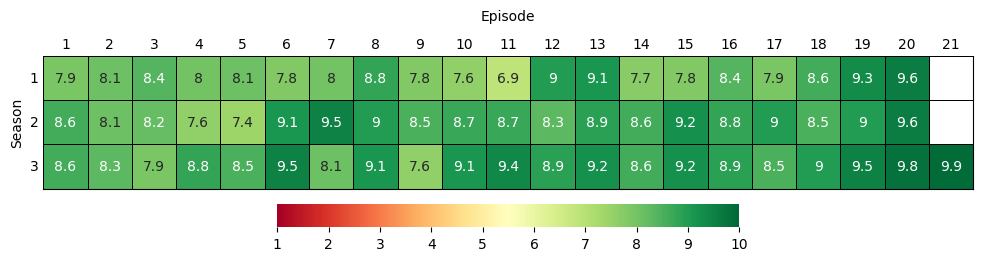

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

subset_df = full_dataset_df.copy()[['season', 'episode', 'rating']]
pivoted_subset_df = subset_df.pivot(index=['season'], columns='episode')

fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(data=pivoted_subset_df,
            vmin=1,
            vmax=10,
            cmap='RdYlGn',
            square=True,
            annot=True,
            cbar=True,
            linecolor='black',
            linewidth=0.5,
            cbar_kws={'location': 'bottom', 'fraction': 0.03, 'pad': 0.02}
            )

ax.set_xlabel('Episode', labelpad=12)
ax.xaxis.set_label_position('top')
ax.set_xticklabels([label.get_text().split('-')[1] for label in ax.get_xticklabels()])
ax.tick_params(axis='x', labelrotation=0, length=0, labeltop=True, labelbottom=False)
ax.set_ylabel('Season')
ax.tick_params(axis='y', labelrotation=0, length=0)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.show()
plt.close()

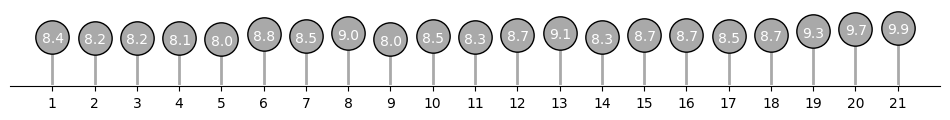

In [147]:
season_average = pivoted_subset_df.mean(axis=1)
episode_average = pivoted_subset_df.mean(axis=0)

fig, ax = plt.subplots(figsize=(12, 1))

plt.stem(episode_average,
         label=episode_average,
         basefmt='white'
         )

for c, child in enumerate(ax.get_children()):
    if c == 0: #stem lines
        child.set_color('darkgray')
        child.set_linewidth(2)
    elif c == 1: # marker lines
        child.set_markerfacecolor('darkgray')
        child.set_markeredgecolor('black')
        child.set_markersize(24)

ax.set_xlim(-1, 21)
ax.set_xticks(range(0, 21))
ax.set_xticklabels(range(1, 22))
ax.set_ylim(0, 13)
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
ax.spines[['left', 'top', 'right']].set_visible(False)

rounded_episode_average = episode_average.copy().values.round(decimals=1)
for i, rounded_average in enumerate(rounded_episode_average):
    ax.annotate(str(rounded_average), xy=(i-0.25,rounded_average-1), color='white')

plt.show()
plt.close()

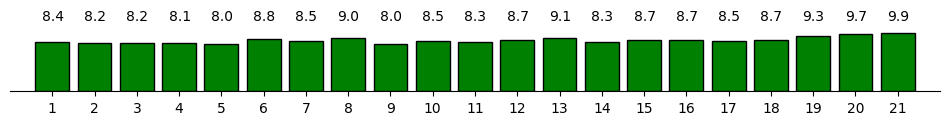

In [320]:
season_average = pivoted_subset_df.mean(axis=1).reset_index().rename(columns={0: 'rating'})
episode_average = pivoted_subset_df.mean(axis=0).reset_index().drop(columns=['level_0']).rename(columns={0: 'rating'})

bar_colors = []
for rating in episode_average['rating']:
    rounded_rating = round(rating, 1)
    if rounded_rating >= 8.0:
        bar_colors.append('green')
    elif 6.0 <= rounded_rating < 8.0:
        bar_colors.append('lightgreen')
    elif 4.0 <= rounded_rating < 6.0:
        bar_colors.append('gold')
    elif 2.0 <= rounded_rating < 4.0:
        bar_colors.append('orange')
    else:
        bar_colors.append('red')

fig, ax = plt.subplots(figsize=(12, 1))

sns.barplot(data=episode_average,
            x='episode',
            y='rating'
            )

for c, child in enumerate(ax.get_children()):
    if c < episode_average['episode'].max():
        child.set_color(bar_colors[c])
        child.set_edgecolor('black')
    else:
        break

ax.set_xlim(-1, 21)
ax.set_xlabel('')
ax.set_ylim(0, 13)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
ax.spines[['left', 'top', 'right']].set_visible(False)

rounded_episode_average = episode_average.copy()['rating'].values.round(decimals=1)
for i, rounded_average in enumerate(rounded_episode_average):
    ax.annotate(str(rounded_average), xy=(i-0.25,12), color='black')

plt.show()
plt.close()

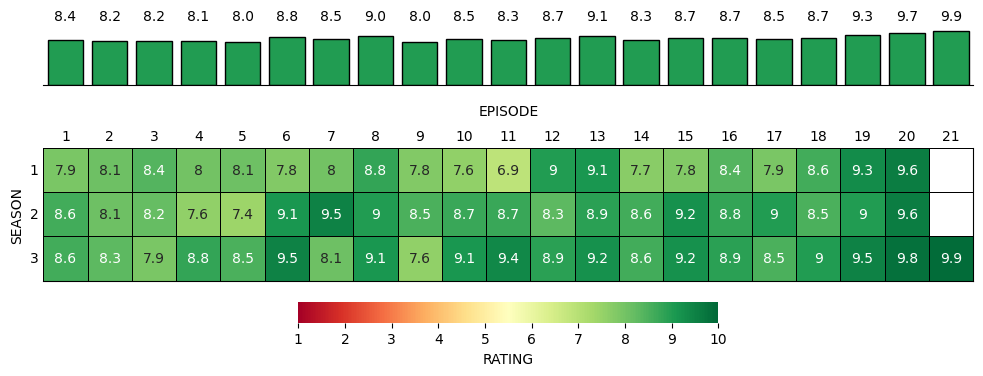

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns

subset_df = full_dataset_df.copy()[['season', 'episode', 'rating']]
pivoted_subset_df = subset_df.pivot(index=['season'], columns='episode')

season_average = pivoted_subset_df.mean(axis=1).reset_index().rename(columns={0: 'rating'})
episode_average = pivoted_subset_df.mean(axis=0).reset_index().drop(columns=['level_0']).rename(columns={0: 'rating'})

fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=True,
                         figsize=(12,4),
                         gridspec_kw={'height_ratios': [0.25, 0.75]}
                         )

bar_colors = []
for rating in episode_average['rating']:
    rounded_rating = round(rating, 1)
    if rounded_rating >= 8.0:
        bar_colors.append('#219C52')
    elif 6.0 <= rounded_rating < 8.0:
        bar_colors.append('#BDE379')
    elif 4.0 <= rounded_rating < 6.0:
        bar_colors.append('#FEDF8A')
    elif 2.0 <= rounded_rating < 4.0:
        bar_colors.append('#F7854E')
    else:
        bar_colors.append('#BB1526')

sns.barplot(data=episode_average,
            x='episode',
            y='rating',
            ax=axes[0]
            )

for c, child in enumerate(axes[0].get_children()):
    if c < episode_average['episode'].max():
        child.set_color(bar_colors[c])
        child.set_edgecolor('black')
        current_x = child.get_x()
        child.set_x(current_x + 0.5)
    else:
        break

axes[0].set_xlim(-1, 21)
axes[0].set_xlabel('')
axes[0].set_ylim(0, 13)
axes[0].set_ylabel('')
axes[0].set_yticklabels([])
axes[0].tick_params(axis='both', length=0)
axes[0].spines[['left', 'top', 'right']].set_visible(False)

rounded_episode_average = episode_average.copy()['rating'].values.round(decimals=1)
for i, rounded_average in enumerate(rounded_episode_average):
    axes[0].annotate(str(rounded_average), xy=(i+0.25,12), color='black')

sns.heatmap(data=pivoted_subset_df,
            vmin=1,
            vmax=10,
            cmap='RdYlGn',
            square=True,
            annot=True,
            cbar=True,
            linecolor='black',
            linewidth=0.5,
            cbar_kws={'location': 'bottom', 'label': 'RATING', 'fraction': 0.1, 'pad': 0.1},
            ax=axes[1]
            )

axes[1].set_xlabel('EPISODE', labelpad=10)
axes[1].xaxis.set_label_position('top')
axes[1].set_xticklabels([label.get_text().split('-')[1] for label in axes[1].get_xticklabels()])
axes[1].tick_params(axis='x', labelrotation=0, length=0, labeltop=True, labelbottom=False)
axes[1].set_ylabel('SEASON')
axes[1].tick_params(axis='y', labelrotation=0, length=0)
axes[1].spines['right'].set_visible(True)
axes[1].spines['bottom'].set_visible(True)

plt.show()
plt.close()

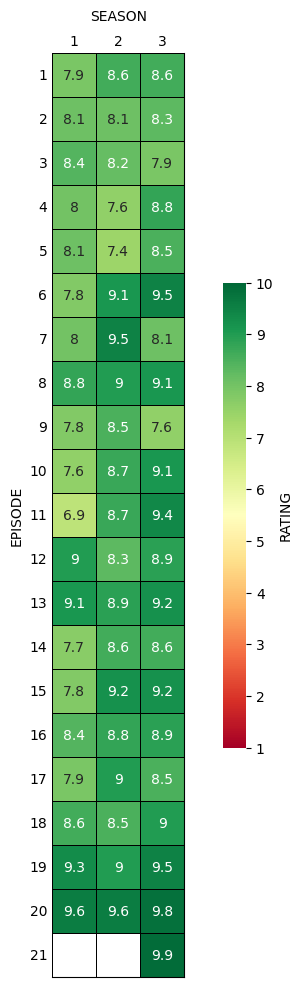

In [419]:
import matplotlib.pyplot as plt
import seaborn as sns

subset_df = full_dataset_df.copy()[['season', 'episode', 'rating']]
pivoted_subset_df = subset_df.pivot(index=['episode'], columns='season')

episode_average = pivoted_subset_df.mean(axis=1).reset_index().rename(columns={0: 'rating'})
season_average = pivoted_subset_df.mean(axis=0).reset_index().drop(columns=['level_0']).rename(columns={0: 'rating'})

fig, ax = plt.subplots(figsize=(10,12))

sns.heatmap(data=pivoted_subset_df,
            vmin=1,
            vmax=10,
            cmap='RdYlGn',
            square=True,
            annot=True,
            cbar=True,
            linecolor='black',
            linewidth=0.5,
            cbar_kws={'location': 'right', 'label': 'RATING', 'fraction': 0.03}
            )

ax.set_xlabel('SEASON', labelpad=10)
ax.xaxis.set_label_position('top')
ax.set_xticklabels([label.get_text().split('-')[1] for label in ax.get_xticklabels()])
ax.tick_params(axis='x', labelrotation=0, length=0, labeltop=True, labelbottom=False)
ax.set_ylabel('EPISODE')
ax.tick_params(axis='y', labelrotation=0, length=0)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.show()
plt.close()

C:\Users\migue\AppData\Local\Temp\ipykernel_15992\1134337460.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


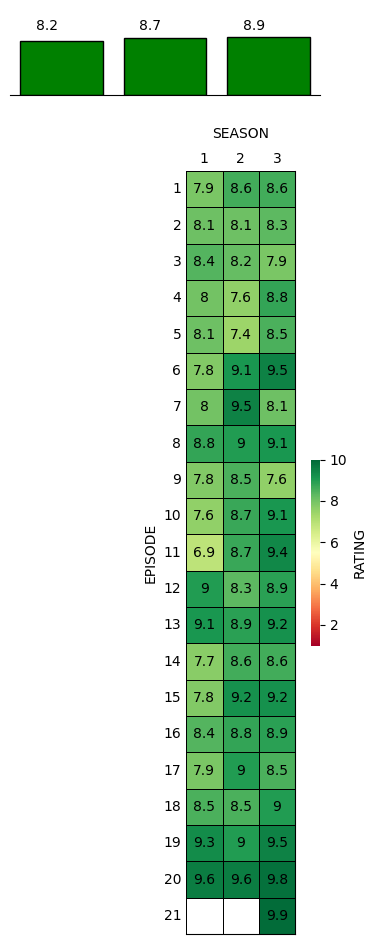

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

subset_df = full_dataset_df.copy()[['season', 'episode', 'rating']]
pivoted_subset_df = subset_df.pivot(index=['episode'], columns='season')

episode_average = pivoted_subset_df.mean(axis=1).reset_index().rename(columns={0: 'rating'})
season_average = pivoted_subset_df.mean(axis=0).reset_index().drop(columns=['level_0']).rename(columns={0: 'rating'})

fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=True,
                         figsize=(4,12),
                         gridspec_kw={'height_ratios': [0.10, 0.90], 'hspace': 0.18}
                         )

bar_colors = []
for rating in season_average['rating']:
    rounded_rating = round(rating, 1)
    if rounded_rating >= 8.0:
        bar_colors.append('green')
    elif 6.0 <= rounded_rating < 8.0:
        bar_colors.append('lightgreen')
    elif 4.0 <= rounded_rating < 6.0:
        bar_colors.append('gold')
    elif 2.0 <= rounded_rating < 4.0:
        bar_colors.append('orange')
    else:
        bar_colors.append('red')

sns.barplot(data=season_average,
            x='season',
            y='rating',
            ax=axes[0]
            )

for c, child in enumerate(axes[0].get_children()):
    if c < season_average['season'].max():
        child.set_color(bar_colors[c])
        child.set_edgecolor('black')
        current_x = child.get_x()
        child.set_x(current_x + 0.5)
    else:
        break

axes[0].set_xlim(-1, 3)
axes[0].set_xlabel('')
axes[0].set_ylim(0, 13)
axes[0].set_ylabel('')
axes[0].set_yticklabels([])
axes[0].tick_params(axis='both', length=0)
axes[0].spines[['left', 'top', 'right']].set_visible(False)

rounded_season_average = season_average.copy()['rating'].values.round(decimals=1)
for i, rounded_average in enumerate(rounded_season_average):
    axes[0].annotate(str(rounded_average), xy=(i+0.25,10), color='black')

sns.heatmap(data=pivoted_subset_df,
            vmin=1,
            vmax=10,
            cmap='RdYlGn',
            square=True,
            annot=True,
            annot_kws={'color': 'black'},
            cbar=True,
            linecolor='black',
            linewidth=0.5,
            cbar_kws={'location': 'right', 'label': 'RATING', 'fraction': 0.03},
            ax=axes[1]
            )

axes[1].set_xlabel('SEASON', labelpad=10)
axes[1].xaxis.set_label_position('top')
axes[1].set_xticklabels([label.get_text().split('-')[1] for label in axes[1].get_xticklabels()])
axes[1].tick_params(axis='x', labelrotation=0, length=0, labeltop=True, labelbottom=False)
axes[1].set_ylabel('EPISODE')
axes[1].tick_params(axis='y', labelrotation=0, length=0)
axes[1].spines['right'].set_visible(True)
axes[1].spines['bottom'].set_visible(True)

plt.tight_layout()

plt.show()
plt.close()

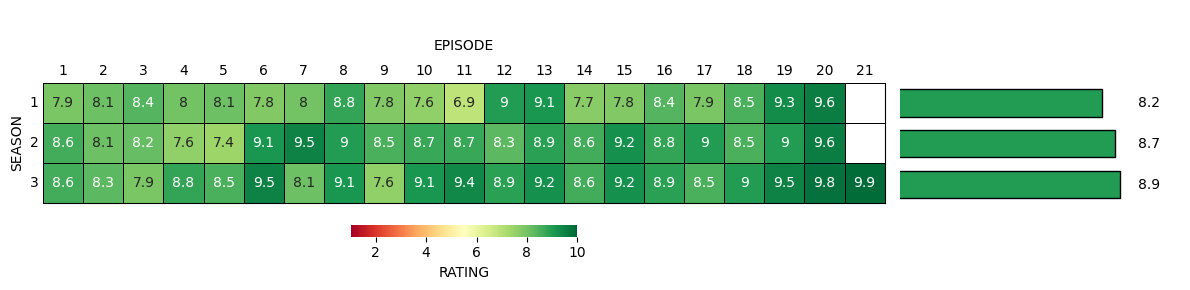

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

subset_df = full_dataset_df.copy()[['season', 'episode', 'rating']]
pivoted_subset_df = subset_df.pivot(index=['season'], columns='episode')

season_average = pivoted_subset_df.mean(axis=1).reset_index().rename(columns={0: 'rating'})
episode_average = pivoted_subset_df.mean(axis=0).reset_index().drop(columns=['level_0']).rename(columns={0: 'rating'})

fig, axes = plt.subplots(nrows=1,
                         ncols=2,
                         figsize=(12,3),
                         gridspec_kw={'width_ratios': [0.75, 0.25]}
                         )

bar_colors = []
for rating in episode_average['rating']:
    rounded_rating = round(rating, 1)
    if rounded_rating >= 8.0:
        bar_colors.append('#219C52')
    elif 6.0 <= rounded_rating < 8.0:
        bar_colors.append('#BDE379')
    elif 4.0 <= rounded_rating < 6.0:
        bar_colors.append('#FEDF8A')
    elif 2.0 <= rounded_rating < 4.0:
        bar_colors.append('#F7854E')
    else:
        bar_colors.append('#BB1526')

sns.heatmap(data=pivoted_subset_df,
            vmin=1,
            vmax=10,
            cmap='RdYlGn',
            square=True,
            annot=True,
            cbar=True,
            linecolor='black',
            linewidth=0.5,
            cbar_kws={'location': 'bottom', 'label': 'RATING', 'fraction': 0.05, 'pad': 0.1},
            ax=axes[0]
            )

axes[0].set_xlabel('EPISODE', labelpad=10)
axes[0].xaxis.set_label_position('top')
axes[0].set_xticklabels([label.get_text().split('-')[1] for label in axes[0].get_xticklabels()])
axes[0].tick_params(axis='x', labelrotation=0, length=0, labeltop=True, labelbottom=False)
axes[0].set_ylabel('SEASON')
axes[0].tick_params(axis='y', labelrotation=0, length=0)
axes[0].spines['right'].set_visible(True)
axes[0].spines['bottom'].set_visible(True)

sns.barplot(data=season_average,
            x='rating',
            y='season',
            orient='horizontal',
            ax=axes[1]
            )

for c, child in enumerate(axes[1].get_children()):
    if c < season_average['season'].max():
        child.set_color(bar_colors[c])
        child.set_edgecolor('black')
        current_y = child.get_y()
        child.set_y(current_y + 0.15 - (0.1 * c))
        current_height = child.get_height()
        child.set_height(0.6)
    else:
        break

axes[1].set_xlim(1, 11)
axes[1].set_xlabel('')
axes[1].set_xticklabels([])
axes[1].set_ylim(-2, 3)
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].invert_yaxis()
axes[1].tick_params(axis='both', length=0)
axes[1].spines[['bottom', 'top', 'left', 'right']].set_visible(False)

rounded_season_average = season_average.copy()['rating'].values.round(decimals=1)
for i, rounded_average in enumerate(rounded_season_average):
    axes[1].annotate(str(rounded_average), xy=(9.5, i+0.15-(0.1*i)), color='black')

plt.tight_layout()
plt.show()
plt.close()